# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

Study on simple random sinusoidal images vs. real valued bent functions (maximaly non-linear) images

### Simple sinusoidal images:
Generate sinusoidal data with random phase and frequency:

$$Z = \sin(2\pi f_x x + \phi_x) \cos(2\pi f_y y + \phi_y)$$

Where:
- $f_x$ is the frequency multiplier for x
- $f_y$ is the frequency multiplier for y
- $\phi_x$ is the phase shift for x
- $\phi_y$ is the phase shift for y

### Real valued Bent functions:

$$Z = \cos(2\pi(aX + bY)) + \cos(2\pi(cX - dY))$$

Where $a$, $b$, $c$, and $d$ are parameters controlling the function's behavior.



## Imports and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo

In [3]:
import polcanet.reports as report
import polcanet.utils as ut
from polcanet import PolcaNet

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [4]:
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="SYNTH_dataset",
    description="POLCA-Net on Synthetic Sinudosial and Bent Images",
    random_seed=random_seed,
)
ut.set_save_fig(True)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving Images: True, saving in path: /data1/deploy/polcanet/examples/notebooks/experiments/SYNTH_dataset


## Generate Synthetic Sinudosial and Bent Images

7.748604e-07 0.9999964
0.0 1.0


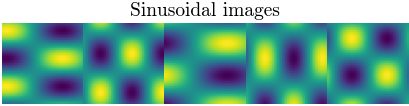

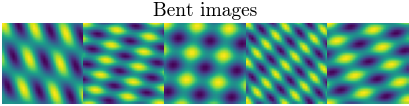

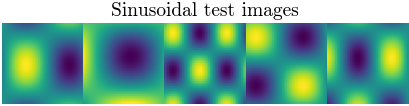

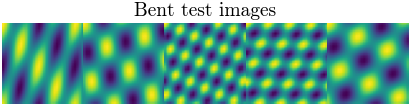

In [5]:
# Parameters
N = 32  # rows
M = 32  # cols
num_samples = 1000

# Generate 2D sinusoidal data
data_sin = ut.generate_2d_sinusoidal_data(N, M, num_samples=num_samples)
data_sin_test = ut.generate_2d_sinusoidal_data(N, M, num_samples=num_samples)

# Generate 2D real bent function images data
data_bent = ut.generate_bent_images(N, M, num_samples=3000)
data_bent_test = ut.generate_bent_images(N, M, num_samples=num_samples)
print(data_sin.min(), data_sin.max())
print(data_bent.min(), data_bent.max())
ut.set_fig_prefix("sin_train")
ut.plot_train_images(data_sin, "Sinusoidal images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_train")
ut.plot_train_images(data_bent, "Bent images", cmap="viridis", n=5)

ut.set_fig_prefix("sin_test")
ut.plot_train_images(data_sin_test, "Sinusoidal test images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_test")
ut.plot_train_images(data_bent_test, "Bent test images", cmap="viridis", n=5)

### Perform PCA on datasets

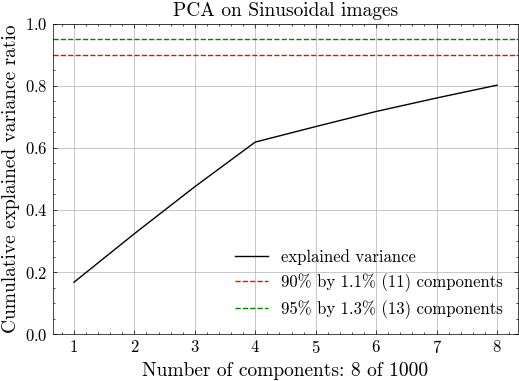

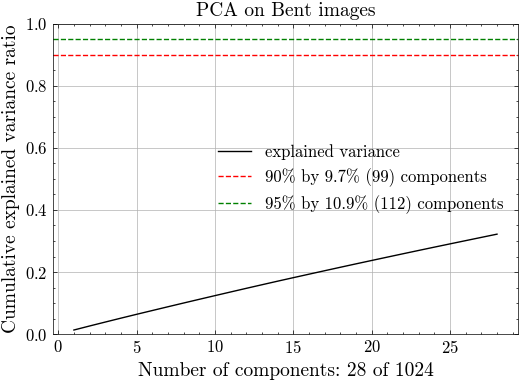

In [6]:
n_components = 8  # int((N*M)//100)
ut.set_fig_prefix("sin")
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, layout="constrained")
pca_sin = ut.get_pca(data_sin, ax=axs, title="PCA on Sinusoidal images", n_components=n_components)
plt.show()

n_components = 28
ut.set_fig_prefix("bent")
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, layout="constrained")
pca_bent = ut.get_pca(data_bent, ax=axs, title="PCA on Bent images", n_components=n_components)
plt.show()

## POLCA-Net

### Train on Sinusoidal Images

In [7]:
from polcanet.aencoders import ConvEncoder, LinearDecoder

ae_input = data_sin
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_sin.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder_sin = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_sin = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5 * 256,
    num_layers=4,
    act_fn=act_fn,
    bias=False,
    output_act_fn = torch.nn.Sigmoid,
)

model_sin = PolcaNet(
    encoder=encoder_sin,
    decoder=decoder_sin,
    latent_dim=latent_dim,
    alpha=1e-2,  # ortgogonality loss
    beta=1e-2,  # variance sorting loss
    gamma=1e-5,  # variance reduction loss
)
print(model_sin)
summary = torchinfo.summary(
    model_sin,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model_sin), "model_sin.txt")
ut.save_text(str(summary), "model_sin_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (2): SiLU()
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): SiLU()
        (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): SiLU()
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (8): SiLU()
        (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): SiLU()
        (11): Flatten(start_dim=1, end_dim=-1)
        (12): Linear(in_features=1024, out_features=32, bias=True)
        (13): SiLU()
        (14): Linear(in_features=32, out_features=8, bias=True)
      )
    )
    (post_encoder): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1)

In [8]:
model_sin.to("cuda")
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.001629
Reconstruction Loss: 0.0002041
Orthogonality Loss: 0.001367
Center of Mass Loss: 0.016
Variance Reduction Loss: 0.01541
Instance Orthogonality Loss: 0.1251


In [9]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.0001319
Reconstruction Loss: 0.0001081
Orthogonality Loss: 0.0007074
Center of Mass Loss: 0.001634
Variance Reduction Loss: 0.04671


In [10]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.0001238
Reconstruction Loss: 9.742e-05
Orthogonality Loss: 0.001042
Center of Mass Loss: 0.001551
Variance Reduction Loss: 0.04549


Loss Interaction Analysis Report:
Total interactions: 4700
Total conflicts: 1143
Overall conflict rate: 0.2432

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,com,iort,470,437,0.930,-0.456,Strongly Conflicting
1,ort,com,470,151,0.321,-0.041,Weakly Conflicting
2,ort,var,470,33,0.070,-0.014,Weakly Conflicting
3,com,var,470,152,0.323,-0.008,Weakly Conflicting
4,rec,com,470,102,0.217,0.011,Weakly Cooperative
5,rec,var,470,72,0.153,0.012,Weakly Cooperative
6,ort,iort,470,46,0.098,0.102,Strongly Cooperative
7,rec,iort,470,55,0.117,0.112,Strongly Cooperative
8,rec,ort,470,75,0.160,0.123,Strongly Cooperative
9,var,iort,470,20,0.043,0.168,Strongly Cooperative


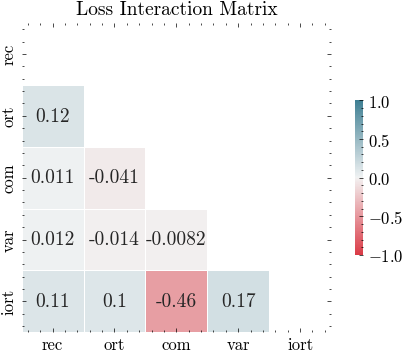

In [10]:
ut.set_fig_prefix("sin_train")
model_sin.loss_analyzer.print_report()
model_sin.loss_analyzer.plot_correlation_matrix()

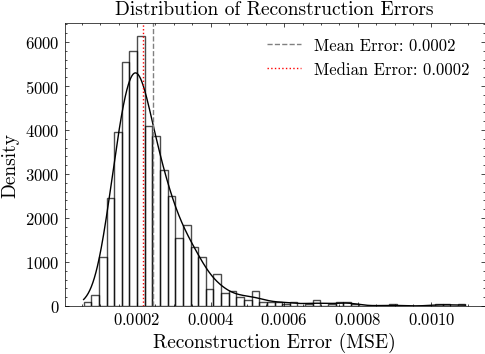

Mean Reconstruction Error: 0.0002
Median Reconstruction Error: 0.0002
Min Reconstruction Error: 0.0001
Max Reconstruction Error: 0.0011


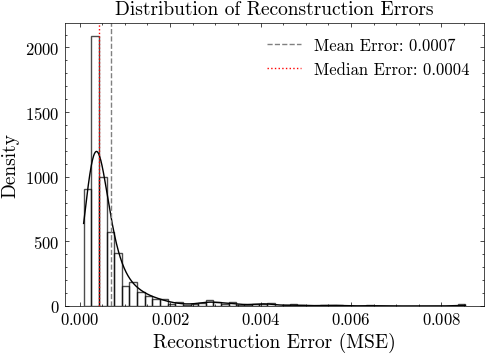

Mean Reconstruction Error: 0.0007
Median Reconstruction Error: 0.0004
Min Reconstruction Error: 0.0001
Max Reconstruction Error: 0.0085


In [11]:
ut.set_fig_prefix("sin_train")
report.analyze_reconstruction_error(model_sin, data_sin, n_samples=1000)
ut.set_fig_prefix("sin_test")
report.analyze_reconstruction_error(model_sin, data_sin_test, n_samples=1000)

In [12]:
latents, reconstructed = model_sin.predict(data_sin)
data_sin.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 8))

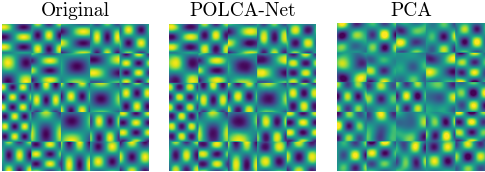

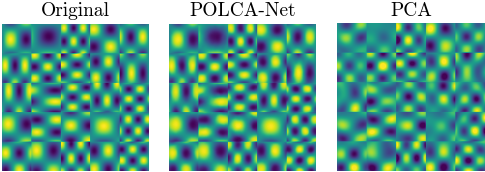

In [13]:
ut.set_fig_prefix("sin_train")
images = data_sin[0:25]
ut.plot_reconstruction_comparison(model_sin, pca_sin, images, cmap="viridis", nrow=5)
ut.set_fig_prefix("sin_test")
images = data_sin_test[0:25]
ut.plot_reconstruction_comparison(model_sin, pca_sin, images, cmap="viridis", nrow=5)

,Metric,Value
0,Mean cosine similarity,0.010990
1,Median cosine similarity,0.006977
2,Standard deviation of cosine similarity,0.011366
3,Max cosine similarity,0.055810
4,Min cosine similarity,0.000433


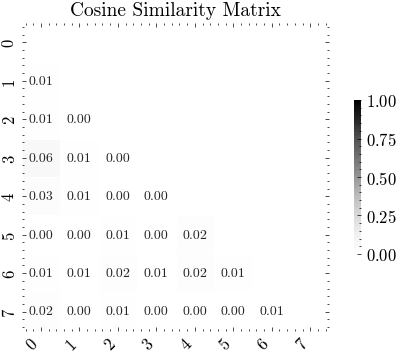

,Metric,Value
0,Mean mutual information,0.041156
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.072079
3,Max mutual information,0.453068
4,Min mutual information,0.000000


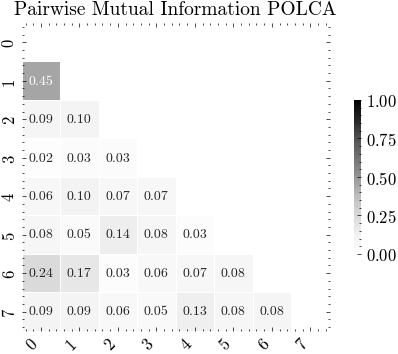

,Metric,Value
0,Mean mutual information,0.034647
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.050512
3,Max mutual information,0.188622
4,Min mutual information,0.000000


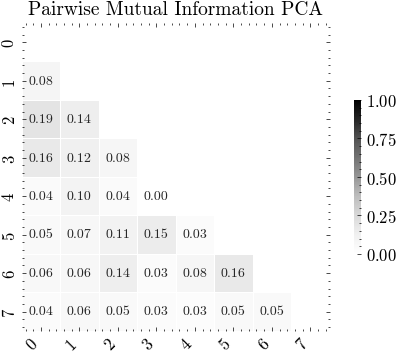

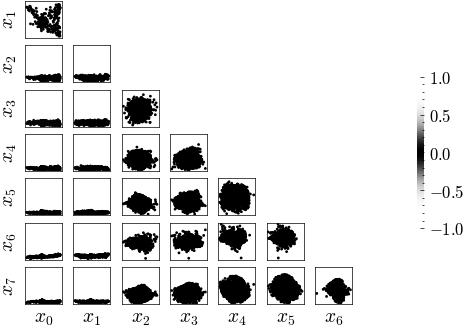

,Metric,Value
0,Mean cosine similarity,0.045080
1,Median cosine similarity,0.039698
2,Standard deviation of cosine similarity,0.034168
3,Max cosine similarity,0.135035
4,Min cosine similarity,0.000862


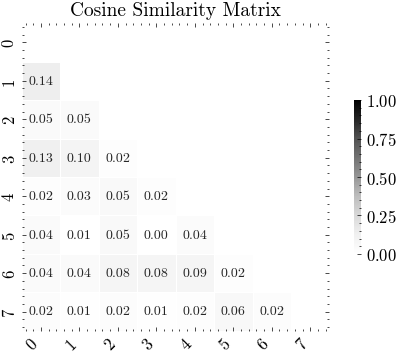

,Metric,Value
0,Mean mutual information,0.039439
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.064798
3,Max mutual information,0.374841
4,Min mutual information,0.000000


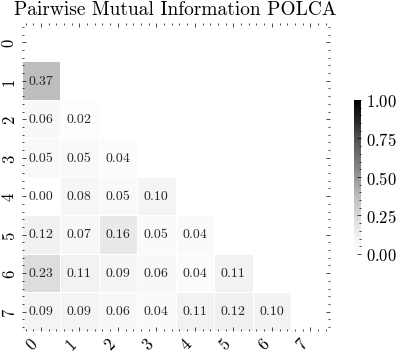

,Metric,Value
0,Mean mutual information,0.035155
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.044746
3,Max mutual information,0.133399
4,Min mutual information,0.000000


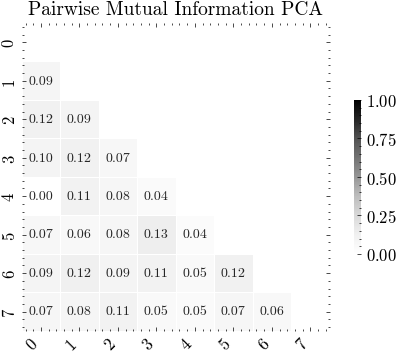

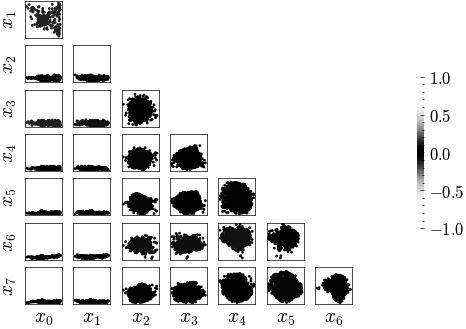

In [14]:
ut.set_fig_prefix("sin_train")
report.orthogonality_test_analysis(model_sin,pca_sin, data_sin)
ut.set_fig_prefix("sin_test")
report.orthogonality_test_analysis(model_sin,pca_sin, data_sin_test)

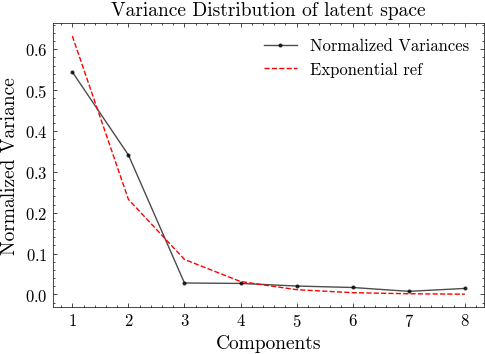

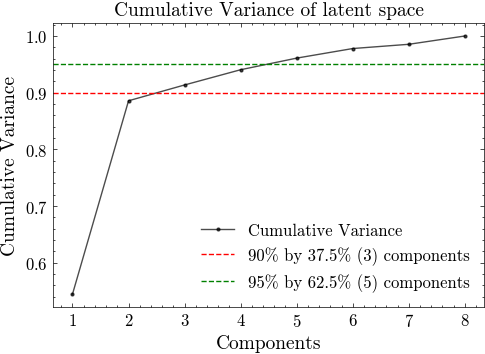

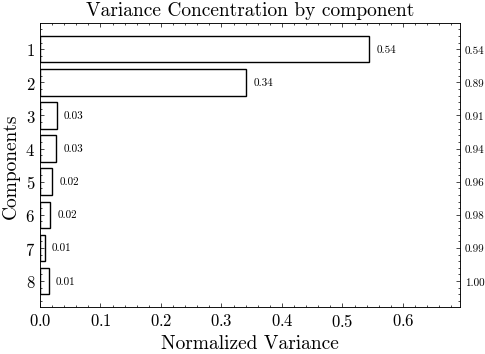

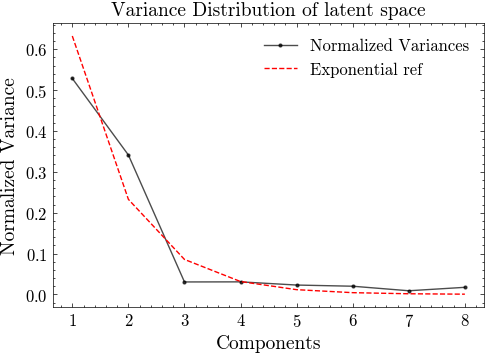

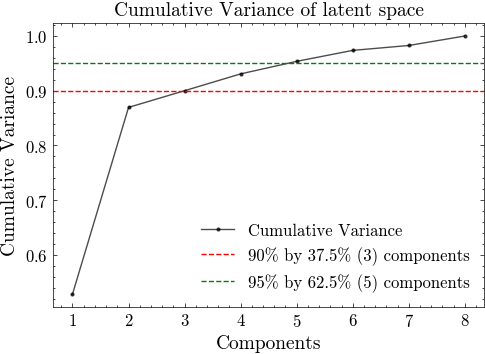

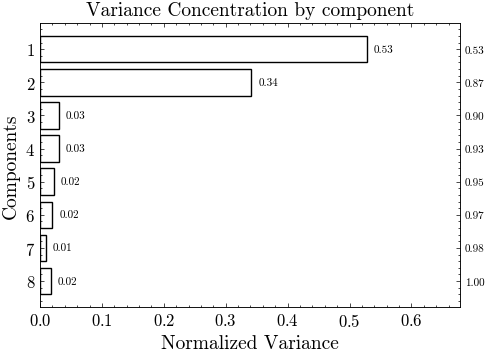

In [15]:
ut.set_fig_prefix("sin_train")
report.variance_test_analysis(model_sin, data_sin)
ut.set_fig_prefix("sin_test")
report.variance_test_analysis(model_sin, data_sin_test)

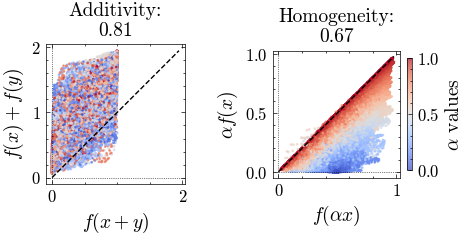

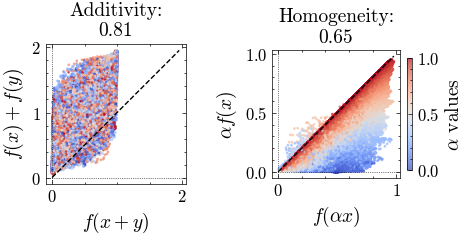

In [16]:
ut.set_fig_prefix("sin_train")
report.linearity_tests_analysis(model_sin, data_sin, alpha_min=0, num_samples=200)
ut.set_fig_prefix("sin_test")
report.linearity_tests_analysis(model_sin, data_sin_test, alpha_min=0, num_samples=200)

### Train on Bent Images

In [17]:
from polcanet.aencoders import ConvEncoder, LinearDecoder
ae_input = data_bent
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_bent.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_bent = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_bent = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5 * 256,
    num_layers=4,
    act_fn=act_fn,
    bias=False,
)

model_bent = PolcaNet(
    encoder=encoder_bent,
    decoder=decoder_bent,
    latent_dim=latent_dim,
    alpha=1e-2,  # ortgogonality loss
    beta=1e-2,  # variance sorting loss
    gamma=1e-5,  # variance reduction loss
)
print(model_bent)
summary = torchinfo.summary(
    model_bent,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model_bent), "model_bent.txt")
ut.save_text(str(summary), "model_bent_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (2): SiLU()
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): SiLU()
        (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): SiLU()
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (8): SiLU()
        (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): SiLU()
        (11): Flatten(start_dim=1, end_dim=-1)
        (12): Linear(in_features=1024, out_features=112, bias=True)
        (13): SiLU()
        (14): Linear(in_features=112, out_features=28, bias=True)
      )
    )
    (post_encoder): Sequential(
      (0): Linear(in_features=28, out_features=28, bias=True)
    

In [18]:
model_bent.to("cuda")
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Training interrupted by user.


In [19]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Training interrupted by user.


In [20]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Training interrupted by user.


Loss Interaction Analysis Report:
Total interactions: 29480
Total conflicts: 4600
Overall conflict rate: 0.1560

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,com,iort,2948,2941,0.998,-0.556,Strongly Conflicting
1,rec,var,2948,454,0.154,-0.016,Weakly Conflicting
2,rec,com,2948,523,0.177,-0.010,Weakly Conflicting
3,rec,iort,2948,239,0.081,0.032,Weakly Cooperative
4,com,var,2948,0,0.000,0.051,Weakly Cooperative
5,rec,ort,2948,129,0.044,0.055,Weakly Cooperative
6,ort,com,2948,32,0.011,0.058,Weakly Cooperative
7,ort,var,2948,82,0.028,0.068,Weakly Cooperative
8,var,iort,2948,200,0.068,0.074,Weakly Cooperative
9,ort,iort,2948,0,0.000,0.430,Strongly Cooperative


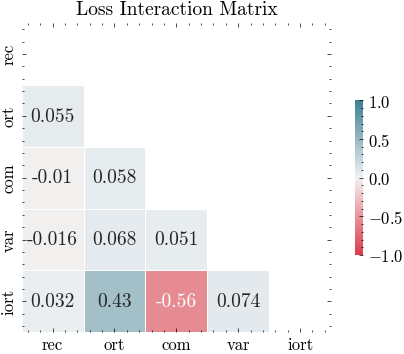

In [21]:
ut.set_fig_prefix("bent_train")
model_bent.loss_analyzer.print_report()
model_bent.loss_analyzer.plot_correlation_matrix()

In [ ]:
ut.set_fig_prefix("bent_train")
report.analyze_reconstruction_error(model_bent, data_bent, n_samples=1000)
ut.set_fig_prefix("bent_test")
report.analyze_reconstruction_error(model_bent, data_bent_test, n_samples=1000)

In [ ]:
latents, reconstructed = model_bent.predict(data_bent)
data_bent.shape, reconstructed.shape, latents.shape

In [ ]:
ut.set_fig_prefix("sin_train")
images = data_bent[0:25]
ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=5)
ut.set_fig_prefix("sin_test")
images = data_bent_test[0:25]
ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=5)

In [ ]:
ut.set_fig_prefix("bent_train")
report.orthogonality_test_analysis(model_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.orthogonality_test_analysis(model_bent, data_bent_test)

In [ ]:
ut.set_fig_prefix("bent_train")
report.variance_test_analysis(model_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.variance_test_analysis(model_bent, data_bent_test)

In [ ]:
ut.set_fig_prefix("bent_train")
report.linearity_tests_analysis(model_bent, data_bent, alpha_min=0, num_samples=200)
ut.set_fig_prefix("bent_test")
report.linearity_tests_analysis(model_bent, data_bent_test, alpha_min=0, num_samples=200)

## Test Overall

In [ ]:
experiment_data = {
    "Sinudoidal": (
        data_sin,
        model_sin,
        pca_sin,
    ),
    "Bent": (
        data_bent,
        model_bent,
        pca_bent,
    ),
}
_ = ut.image_metrics_table(experiment_data)

In [ ]:
def calculate_compressed_size(initial_size: int, compression_rate: float) -> int:
    """
    Calculate the final size after compression.

    Parameters:
    initial_size (int): The original size before compression.
    compression_rate (float): The desired compression rate (as a decimal).
                              For example, 0.5 for 50% compression.

    Returns:
    int: The final size after compression.
    """
    if compression_rate < 0 or compression_rate > 1:
        raise ValueError("Compression rate must be between 0 and 1.")
    
    final_size = initial_size * compression_rate
    return int(final_size)

In [ ]:
# Example usage:
initial_size = 28*28  # Initial size in units (e.g., bytes)
compression_rate = 0.01  # 30% compression rate
compressed_size = max(8,calculate_compressed_size(initial_size, compression_rate))

print(f"The compressed size is {compressed_size} units, from {initial_size} for compression rate {compression_rate}")

In [ ]:
def calculate_compressed_size_and_ratio(initial_size: int, compression_rate: float) -> (int, str):
    """
    Calculate the final size after compression and report the compression ratio.

    Parameters:
    initial_size (int): The original size before compression.
    compression_rate (float): The desired final compression rate (as a decimal).
                              For example, 0.5 means the data is compressed to 50% of the original size.

    Returns:
    tuple: A tuple containing the final size after compression (int) and
           the compression ratio as a string in the format "X:1".
    """
    if compression_rate <= 0 or compression_rate > 1:
        raise ValueError("Compression rate must be between 0 (exclusive) and 1 (inclusive).")
    
    # Calculate the final size after compression
    final_size = initial_size * compression_rate
    compressed_size = int(final_size)
    
    # Calculate the compression ratio
    compression_ratio = initial_size / compressed_size
    compression_ratio_str = f"{compression_ratio:.1f}:1"
    
    return compressed_size, compression_ratio_str

In [ ]:
# Example usage:
initial_size = 32*32  # Initial size in units (e.g., bytes)
compression_rate = 0.01  # The final size will be 70% of the original size
compressed_size, compression_ratio = calculate_compressed_size_and_ratio(initial_size, compression_rate)

print(f"The compressed size is {compressed_size} units.")
print(f"The compression ratio is {compression_ratio}")